# Análise Exploratória no Genoma das Variantes Brasileira e de Wuhan do Novo Coronavírus

## 1. Introdução
### 1.1 Contextualização

No final de 2019, na cidade de Wuhan, foi identificada uma síndrome respiratória altamente infecciosa. No dia 31 de dezembro foi reportado que tal síndrome era causada por um novo coronavírus, o SARS-CoV-2 (EUROPEAN CENTRE FOR DISEASE PREVENTION AND CONTROL, 2020). Coronavírus são vírus de RNA de cadeia simples que ocorrem frequentemente em animais, e alguns deles podem infectar seres humanos. Rapidamente, a doença causada por esse vírus, o COVID-19, já tinha se espalhado por quase todos os países do globo.

O mecanismo de replicação do SARS-CoV-2 envolve a entrada do vírus na célula hospedeira através da interação entre proteínas da "coroa"(*spike*) do vírus com receptores na membrana plasmática. Isso vai promover a síntese de RNA complementar, que vai servir tanto para a tradução de proteínas quanto para a duplicação do RNA que são necessárias às novas cópias dos vírus (REECE, 2019).


<figure>
	<img src = duplicacao_virus.png width=75%>
	<figcaption>Fig 1: Duplicação de vírus de RNA (REECE, 2019)</figcaption>
</figure>


A taxa de mutação é alta porque as enzimas que promovem a duplicação de RNA não possuem mecanismo de correção de erros (FIELDS, 1996). Isso causa uma alta taxa de mutação, onde podemos ver em grande quantidade expressa na Fig.2:


<figure>
	<img src = filogenia.png>
	<figcaption>Fig 2: Duplicação de vírus de RNA (HADFIELD, 2021)</figcaption>
</figure>


Novas variantes causam grande peocupação e esforços na saúde pública, porque algumas mutações podem alterar a taxa de transmissão, além de reduzir a eficácia imunizantes (CLEM, 2011). Uma variante importante que fez aumentar a taxa de ocupação de leitos de UTI no Brasil é a denominada "variante brasileira", a 20J/501Y.V3, da linhagem P.1 (VARIANTE, 2021).

### 1.2 Proposta de Trabalho

Dentro do vasto tema da bioinformática, busca-se realizar uma análise exploratória do genoma da variante 20J/501Y.V3 com objetivo de comparar suas principais características com a variante encontrada inicialmente em Wuhan.

Apesar da análise apresentada nesse trabalho ser essencialmente didática, justifica-se pelo fato de que demonstra o aprendizado de várias habilidades e competências necessárias ao cientista de dados:

 * Aprendizado de novas ferramentas científicas e computacionais necessárias ao domínio do problema
 * Trabalhar a transdisciplinaridade
 * *Storytelling*
 * *Literate Programming* em *notebooks Jupyter*

Além disso, dada a disseminação das ferramentas de análise de dados e computação na pesquisa em saúde pública no contexto atual, os passos dados aqui são os primeiros que normalmente são realizados para obter uma visão geral da genética do vírus, durante a fase de planejamento estratégico de produtos e sistemas biotecnológicos.

## 2. Coleta e Tratamento de Dados

Os dados obtidos estão em formato de texto, com armazenamento de sequências genéticas denominado **.fasta**. É possível armazenar cadeias de DNA, RNA e polipeptídeos nesse formato. cada nucleotídeo ou aminoácido é representado por uma letra, os metadados ficam na primeira linha do arquivo e cada sequência é uma cadeia de caracteres (PEARSON, 1988):

~~~
>MN908947.3:1-29903 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA
~~~
Cada base nitrogenada é representada por uma letra:
 * **A** - Adenina
 * **T** - Timina
 * **G** - Guanina
 * **C** - Citosina
 * **U** - Uracila
 
 As cadeias podem ser realmente longas. O genoma humano possui 3.200.000.000 pares de bases nitrogenadas. A fonte dos dados da variante 20J/501Y.V3 é do estudo realizado em Manaus (FARIA, 2021) e a variante de Wuhan foi obtida da publicação de (LU, 2020).

In [25]:
# BIBLIOTECAS IMPORTADAS
import Bio
# import heapq
import pylab
import urllib
import pandas as pd
import nglview as nv
import dill

from Bio.Seq import Seq
from Bio.Blast import NCBIWWW
#from Bio.Alphabet import IUPAC
from collections import Counter
from Bio.Data import CodonTable
from Bio import SeqIO, SearchIO
from Bio.PDB import PDBParser,MMCIFParser
from Bio.SeqUtils import GC,molecular_weight
# from dna_features_viewer import GraphicFeature, GraphicRecord
#from Bio.Alphabet import generic_dna,generic_rna,generic_protein

A sequência de Wuhan foi baixada do banco de dados do NCBI (PRUTT, 2005), e não precisou de tratamento algum para ser utilizado. Abaixo segue as operações de limpeza de dados realizada no genoma de Manaus:

 * Um arquivo **.fasta** pode ter várias sequências, mas em nosso caso, só são necessárias as duas primeiras linhas, que correspondem à primeira sequência de RNA, então, foi realizado um filtro com o editor de fluxo de Shell Unix **sed**
 * Conversão dos códigos das bases para maiúsculas.
 * Conversão de bases desconhecidas para o código N, (a**N**y, bases não mapeadas que podem sem qualquer uma das 4 disponíveis para RNA.)

In [ ]:
! sed 2q data/CADDE_B.1.1.28_P1.fasta >> data/manaus.fasta
! sed -i '2s/^.*$/\U&/' data/manaus.fasta
! sed -i '2s/\-/N/g' data/manaus.fasta

## 3. Análise e Exploração de Dados

### 3.1 Algumas características básicas das sequências foram obtidas, como tamanho, peso molecular, quantidade de sequências **AGA** e seus complementos:

In [2]:
# Parsing da sequência de Manaus:
for recordm in SeqIO.parse("data/manaus.fasta","fasta"):
    print(recordm)

ID: P1_CADDE-CD1716_hCoV-19/Brazil/L70_CD1716/2020|Brazil_AM_Manaus|2020-12-16
Name: P1_CADDE-CD1716_hCoV-19/Brazil/L70_CD1716/2020|Brazil_AM_Manaus|2020-12-16
Description: P1_CADDE-CD1716_hCoV-19/Brazil/L70_CD1716/2020|Brazil_AM_Manaus|2020-12-16
Number of features: 0
Seq('AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCAT...AAT')


In [3]:
# Parsing da sequência de Wuhan:
for recordw in SeqIO.parse("data/wuhan.fasta","fasta"):
    print(recordw)

ID: LR757998.1
Name: LR757998.1
Description: LR757998.1 Severe acute respiratory syndrome coronavirus 2 genome assembly, chromosome: whole_genome
Number of features: 0
Seq('AACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTA...AAA')


In [4]:
#Comprimento das sequências
sequencia_manaus = recordm.seq
sequencia_wuhan = recordw.seq
print('Manaus: ', len(sequencia_manaus))
print('Wuhan: ',len(sequencia_wuhan))

Manaus:  29615
Wuhan:  29866


In [5]:
#Peso molecular:
#print('Manaus: ', molecular_weight(sequencia_manaus))
print('Wuhan: ',molecular_weight(sequencia_wuhan))

Wuhan:  9229800.85750042


In [6]:
#Estabilidade do nucleotídeo através do conteúdo GC:
gcm = (sequencia_manaus.count('G') + sequencia_manaus.count('C'))/(len(sequencia_manaus)) * 100
gcw = (sequencia_wuhan.count('G') + sequencia_wuhan.count('C'))/(len(sequencia_wuhan)) * 100
print('Manaus: ', gcm)
print('Wuhan: ', gcw)

Manaus:  36.31605605267601
Wuhan:  37.98633898078082


### 3.2 Análise do conteúdo proteico:

Para esa seção, foi utilizado o genoma do vírus de Wuhan, porque possui mapeamento genético completo:

In [7]:
#Transcrição do vírus em RNA mensageiro:
mRNA_wuhan = sequencia_wuhan.transcribe()
mRNA_manaus = sequencia_manaus.transcribe()

In [8]:
#Tradução do RNA mensageiro em proteínas:
protein_seq_wuhan = sequencia_wuhan.translate()
protein_seq_manaus = sequencia_manaus.translate()

/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [9]:
#Impressão da tabela de códons
print(CodonTable.unambiguous_dna_by_id[1])

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

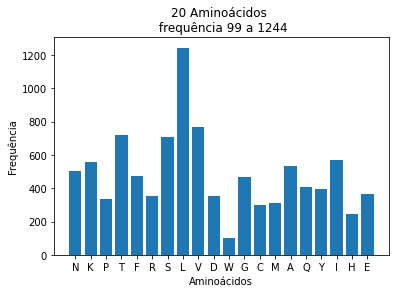

In [10]:
#Aminoácidos mais comuns da variante de Wuhan:
common_amino_w = Counter(protein_seq_wuhan)
common_amino_m = Counter(protein_seq_manaus)
common_amino_w.most_common(10)
del common_amino_w['*']
pylab.bar(common_amino_w.keys(),common_amino_w.values())
pylab.title("%i Aminoácidos \n frequência %i a %i" 
            % (len(common_amino_w.values()), 
               min(common_amino_w.values()), 
               max(common_amino_w.values())))
pylab.xlabel("Aminoácidos")
pylab.ylabel("Frequência")
pylab.plot

In [11]:
#Criação de um Dataframe com as proteínas:
protein_list_wuhan = [str(i) for i in protein_seq_wuhan.split('*')]
protein_list_manaus = [str(i) for i in protein_seq_manaus.split('*')]
df_w = pd.DataFrame({'protein_seq_wuhan':protein_list_wuhan})
df_m = pd.DataFrame({'protein_seq_manaus':protein_list_manaus})
df_w['length'] = df_w['protein_seq_wuhan'].apply(len)
df_m['length'] = df_m['protein_seq_manaus'].apply(len)
df_w.sort_values(by = ['length'], ascending = False)[:10]

,protein_seq_wuhan,length
3,PKGKMESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEA...,4409
175,LEKTTELLFLVMFLLTTKRTMFVFLVLLPLVSSQCVNLTTRTQLPP...,1293
248,RSCCFRFHLNEQTKMSDNGPQNQRNAPRITFGGPSDSTGSNQNGER...,433
47,VKWSCVAVHYMLNQVEPHQEMPQLLMLIVFLTFVKLSRPMLMHFYL...,78
204,VNFPLAVMASNFSLFCACCCLQNKLDHRWNCYRNGLSCRLDVAQLL...,66
68,LTPVLKDSSFLQQKRSKLLRRHLNCLMVLLLYVKCCLTENYIFHGK...,64
120,KNYSILMPHILTNSQMVYAYFGIAMSIDILLIPLFVDLTLECYLTL...,57
75,CHKSTMLELLAYTQHSISQMSFLAMLQIIKRLVCKSILHSRDHLVL...,54
67,AIIVNHINHPLVFHCVLMDKFLVYIKIHVLVAIMLLTLMQLQHVTG...,53
164,LVIVQLYIQLINGISLLVICTTLRLKMLQKKMTLKRVFSLTFVGLYNKS,49


In [12]:
#Buscar a protéina mais longa:

proteina_maior_w = df_w.nlargest(1,'length')
prot_w = proteina_maior_w.iloc[0,0]
with open("data/prot_w.fasta","w") as file:
    file.write(">largest_seq_w \n"+prot_w)

In [13]:
proteina_maior_m = df_m.nlargest(1,'length')
prot_m = proteina_maior_m.iloc[0,0]
with open("data/prot_m.fasta","w") as file:
    file.write(">largest_seq_m \n"+prot_m)

 ### 3.3 Alinhamento de sequências utilizando o Algoritmo BLAST
 
O Algoritmo BLAST (ALTSCHUL, 1990) busca regiões de similaridade entre sequências biológicas. O programa compara sequências de nucleotídeos ou proteínas a bancos de dados de sequências e calcula a significância estatística de similaridade.

In [14]:
seq_prot_w = SeqIO.read("data/prot_w.fasta", "fasta")
seq_prot_m = SeqIO.read("data/prot_m.fasta", "fasta")

In [15]:
%%time

# 2 a 3 minutos

result_handle_w = NCBIWWW.qblast("blastp","pdb",seq_prot_w.seq)
blast_qresult_w = SearchIO.read(result_handle_w, "blast-xml")

CPU times: user 52.8 ms, sys: 10.8 ms, total: 63.5 ms
Wall time: 3min 4s


In [16]:
%%time

# 2 a 3 minutos

result_handle_m = NCBIWWW.qblast("blastp","pdb",seq_prot_m.seq)
blast_qresult_m = SearchIO.read(result_handle_m, "blast-xml")

CPU times: user 73.2 ms, sys: 63.9 ms, total: 137 ms
Wall time: 1min 39s


In [17]:
print(blast_qresult_w[0:5])

Program: blastp (2.11.0+)
  Query: unnamed (4409)
         protein product
 Target: pdb
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      1  pdb|6WUU|A  Chain A, Non-structural protein 3 [Severe a...
            1      1  pdb|7CMD|A  Chain A, Non-structural protein 3 [Severe a...
            2      1  pdb|7CJD|A  Chain A, Non-structural protein 3 [Severe a...
            3      1  pdb|6XAA|A  Chain A, Non-structural protein 3 [Severe a...
            4      1  pdb|6XA9|A  Chain A, Non-structural protein 3 [Severe a...


In [18]:
print(blast_qresult_m[0:5])

Program: blastp (2.11.0+)
  Query: unnamed (2701)
         protein product
 Target: pdb
   Hits: ----  -----  ----------------------------------------------------------
            #  # HSP  ID + description
         ----  -----  ----------------------------------------------------------
            0      1  pdb|6YYT|A  Structure of replicating SARS-CoV-2 polymer...
            1      1  pdb|7D4F|A  Chain A, RNA-directed RNA polymerase [Sever...
            2      1  pdb|6XEZ|A  Chain A, RNA-directed RNA polymerase [Sever...
            3      1  pdb|6XQB|A  Chain A, RNA-directed RNA polymerase [Sever...
            4      1  pdb|7C2K|A  Chain A, RNA-directed RNA polymerase [Sever...


In [19]:
seqid_w = blast_qresult_w[0]
seqid_m = blast_qresult_m[0]

details_w = seqid_w[0]
details_m = seqid_m[0]

print(f"\
Sequence ID:{seqid_w.id}\n\
description:{seqid_w.description}\n\
E value:    {details_w.evalue} \n\
Bit Score:  {details_w.bitscore}\n\
")

print(f"\
Sequence ID:{seqid_m.id}\n\
description:{seqid_m.description}\n\
E value:    {details_m.evalue} \n\
Bit Score:  {details_m.bitscore}\n\
")

Sequence ID:pdb|6WUU|A
description:Chain A, Non-structural protein 3 [Severe acute respiratory syndrome coronavirus 2]
E value:    0.0 
Bit Score:  674.855

Sequence ID:pdb|6YYT|A
description:Structure of replicating SARS-CoV-2 polymerase [Severe acute respiratory syndrome coronavirus 2]
E value:    0.0 
Bit Score:  1934.46



In [20]:
print(f"alignment:\n{details_w.aln}")
print(f"alignment:\n{details_m.aln}")

alignment:
Alignment with 2 rows and 321 columns
LREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVT...VTY unnamed
MREVRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVT...LEH pdb|6WUU|A
alignment:
Alignment with 2 rows and 925 columns
FKRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKT...VLQ unnamed
LNRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKT...VLQ pdb|6YYT|A


### 3.4 Visualizando a estrutura da proteína

In [21]:
seqid_w.id
seqid_w.id.split('|')[1]
urllib.request.urlretrieve('https://files.rcsb.org/download/6WUU.pdb','data/6WUU.pdb')
seqid_m.id
seqid_m.id.split('|')[1]
urllib.request.urlretrieve('https://files.rcsb.org/download/6YYT.pdb','data/6YYT.pdb')

('data/6YYT.pdb', <http.client.HTTPMessage at 0x7f15cd646d00>)

In [26]:
parser = PDBParser()

In [27]:
structure_w = parser.get_structure("6WUU","data/6WUU.pdb")
structure_m = parser.get_structure("6YYT","data/6YYT.pdb")

/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21473.
  warnings.warn(
/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21474.
  warnings.warn(
/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 21476.
  warnings.warn(
/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21478.
  warnings.warn(
/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21481.
  warnings.warn(
/home/rafael/.virtualenvs/pos_proteina/lib/python3.8/si

In [28]:
for chain in structure_m[0]:
    print(f"chainid: {chain.id}")

chainid: A
chainid: B
chainid: C
chainid: D
chainid: P
chainid: Q
chainid: T
chainid: U


In [29]:
for chain in structure_w[0]:
    print(f"chainid: {chain.id}")

chainid: A
chainid: B
chainid: C
chainid: D
chainid: G
chainid: H
chainid: I
chainid: J


In [27]:
dill.dump_session('data/notebook_session.db')

In [30]:
dill.load_session('data/notebook_session.db')

In [10]:
nv.demo()

NGLWidget()

In [31]:
view_w = nv.show_biopython(structure_w)
view_w

NGLWidget()

In [32]:
view_w.render_image()

Image(value=b'', width='99%')

In [33]:
view_m = nv.show_biopython(structure_m)
view_m

NGLWidget()

In [34]:
view_m.render_image()

Image(value=b'', width='99%')

## 4. Referências

ALTSCHUL, Stephen F. et al. Basic local alignment search tool. Journal of molecular biology, v. 215, n. 3, p. 403-410, 1990.

COCK, P. J., ANTAO, T., CHANG, J. T., CHAPMAN, B. A., COX, C. J., DALKE, A., … others. (2009). Biopython: freely available Python tools for computational molecular biology and bioinformatics. *Bioinformatics*, 25(11), 1422–1423.

CLEM, Angela S. Fundamentals of vaccine immunology. *Journal of global infectious diseases*, v. 3, n. 1, p. 73, 2011.

FARIA, Nuno R. et al. Genomics and epidemiology of a novel SARS-CoV-2 lineage in Manaus, Brazil. *medRxiv*, 2021.

FIELDS, Bernard N. et al. Fundamental virology. Philadelphia ePA PA: Lippincott-Raven, 1996.

EUROPEAN CENTRE FOR DISEASE PREVENTION AND CONTROL (União Européia). Disease background of 2019-nCoV. In: Disease background of 2019-nCoV. [S. l.], 11 fev. 2020. Disponível em: https://www.ecdc.europa.eu/en/2019-ncov-background-disease. Acesso em: 17 maio 2020.

HADFIELD, J. et al. Genomic epidemiology of novel coronavirus: global subsampling. Nextstrain: real-time tracking of pathogen evolution, 2021.

LU, Roujian et al. Genomic characterisation and epidemiology of 2019 novel coronavirus: implications for virus origins and receptor binding. *The lancet*, v. 395, n. 10224, p. 565-574, 2020.

PEARSON, William R.; LIPMAN, David J. Improved tools for biological sequence comparison. *Proceedings of the National Academy of Sciences*, v. 85, n. 8, p. 2444-2448, 1988.

PRUITT, Kim D.; TATUSOVA, Tatiana; MAGLOTT, Donna R. NCBI Reference Sequence (RefSeq): a curated non-redundant sequence database of genomes, transcripts and proteins. *Nucleic acids research*, v. 33, n. suppl_1, p. D501-D504, 2005.

REECE, Jane B. et al. Biologia de Campbell. Artmed Editora, 2019.

VARIANTE brasileira já responde por 64,4% dos casos de Covid-19 na cidade de São Paulo. *O Globo*, 26 de março de 2021. Seção Sociedade. Disponível em: <https://oglobo.globo.com/sociedade/coronavirus/variante-brasileira-ja-responde-por-644-dos-casos-de-covid-19-na-cidade-de-sao-paulo-24942787>. Acesso em: 29 de março de 2021

https://virological.org/t/genomic-characterisation-of-an-emergent-sars-cov-2-lineage-in-manaus-preliminary-findings/586/2

http://bioemfoco.com.br/noticia/ace2-proteina-que-facilita-entrada-do-sars-cov-2-no-organismo/